<a href="https://colab.research.google.com/github/ZhihaoDC/TFG/blob/main/source/1%20-%20Dibujo%20del%20grafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment

In [20]:
#!git clone https://github.com/ZhihaoDC/TFG.git

In [21]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/TFG

!git pull

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/TFG
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


# Marvel vs DC dataset

In [6]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [33]:
#Read files and peek
#We will use the following dictionary to define the types of the data, as it can all be str at the time of reading the .csv file
#my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':np.int64, 'Minutes':np.int64, 'Release':np.int64, 'Budget':np.int64, 'Opening Weekend USA':np.int64, 'Gross USA': np.int64, 'Gross Worldwide':np.int64}

#Edited (Minutes and Budget are columns that can't be converted to int)
# my_datatypes ={'Original Title':str, 'Company':str,'Rate':float,'Metascore':int, 'Release':int, 'Opening Weekend USA':int, 'Gross USA': int, 'Gross Worldwide':int}

marvel_dc = pd.read_csv("./TFG/datasets/marvel-vs-dc/db.csv",  encoding='ISO-8859-1')

marvel_dc.head()

,Unnamed: 0,Original Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening Weekend USA,Gross USA,Gross Worldwide
0,1,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,2,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,3,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,4,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,5,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


In [34]:
#Check read
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                 object
Release                  int64
Budget                  object
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

In [35]:
#Convert column dtypes to more suitable dtypes
marvel_dc['Original Title'] = marvel_dc['Original Title'].astype(str)
marvel_dc['Company'] = marvel_dc['Company'].astype(str)
marvel_dc['Minutes'] = marvel_dc['Minutes'].astype(np.int64)
marvel_dc['Budget'] = marvel_dc['Budget'].astype(np.int64)
marvel_dc.dtypes

Unnamed: 0               int64
Original Title          object
Company                 object
Rate                   float64
Metascore                int64
Minutes                  int64
Release                  int64
Budget                   int64
Opening Weekend USA      int64
Gross USA                int64
Gross Worldwide          int64
dtype: object

In [36]:
new_columns = [column.replace(' ','_') for column in marvel_dc.columns] 
marvel_dc.columns = new_columns
print(new_columns)
#Out: ['Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']
#We have to replace'Gross\xa0USA' for a 'Gross_USA'

['Unnamed:_0', 'Original_Title', 'Company', 'Rate', 'Metascore', 'Minutes', 'Release', 'Budget', 'Opening_Weekend_USA', 'Gross\xa0USA', 'Gross_Worldwide']


In [38]:
new_columns = [columns.replace('\xa0','_') for columns in new_columns]
marvel_dc.columns = new_columns

marvel_dc

,Unnamed:_0,Original_Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide
0,1,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,2,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,3,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,4,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,5,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774
5,6,The Avengers,Marvel,8.0,69,143,2012,220000000,207438708,623357910,1518812988
6,7,Iron Man Three,Marvel,7.2,62,130,2013,200000000,174144585,409013994,1214811252
7,8,Thor: The Dark World,Marvel,6.9,54,112,2013,170000000,85737841,206362140,644783140
8,9,Captain America: The Winter Soldier,Marvel,7.7,70,136,2014,170000000,95023721,259766572,714421503
9,10,Guardians of the Galaxy,Marvel,8.0,76,121,2014,170000000,94320883,333176600,772776600


In [ ]:
# dict_new_columns={'Unnamed:_0':'Unnamed:_0', 
#                   'Original_Title':'Original_Title',
#                   'Company':'Company',
#                   'Rate':'Rate',
#                   'Metascore':'Metascore',
#                   'Minutes':'Minutes',
#                   'Release':'Release',
#                   'Budget':'Budget',
#                   'Opening Weekend USA':'Opening Weekend USA',
#                   'Gross\xa0USA':'Gross USA',
#                   'Gross Worldwide':'Gross Worldwide'}
# marvel_dc = marvel_dc.rename(columns= dict_new_columns)
# marvel_dc

In [39]:
#Search for null values
null_values=pd.DataFrame(data=marvel_dc.isnull().any(), columns={'has_null_values'})
null_values

,has_null_values
Unnamed:_0,False
Original_Title,False
Company,False
Rate,False
Metascore,False
Minutes,False
Release,False
Budget,False
Opening_Weekend_USA,False
Gross_USA,False


In [40]:
#Drop non useful columns
marvel_dc = marvel_dc.drop(columns= 'Unnamed:_0')
marvel_dc.head()

,Original_Title,Company,Rate,Metascore,Minutes,Release,Budget,Opening_Weekend_USA,Gross_USA,Gross_Worldwide
0,Iron Man,Marvel,7.9,79,126,2008,140000000,98618668,318604126,585366247
1,The Incredible Hulk,Marvel,6.7,61,112,2008,150000000,55414050,134806913,263427551
2,Iron Man 2,Marvel,7.0,57,124,2010,200000000,128122480,312433331,623933331
3,Thor,Marvel,7.0,57,115,2011,150000000,65723338,181030624,449326618
4,Captain America: The First Avenger,Marvel,6.9,66,124,2011,140000000,65058524,176654505,370569774


## Budget

Budget has an average budget of 184.10 million dollars


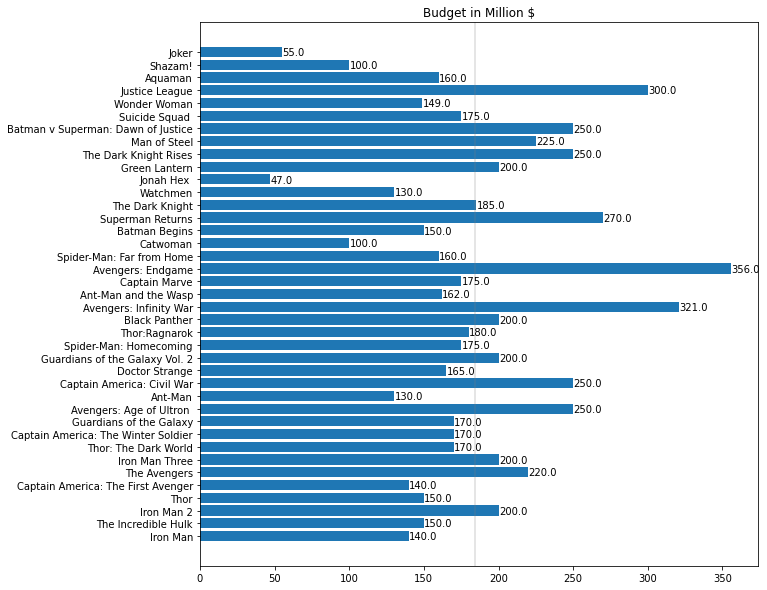

In [42]:
budget_millions = marvel_dc['Budget']/1000000

AVG_BUDGET = statistics.mean(budget_millions)
print('Budget has an average budget of', format(AVG_BUDGET,'.2f') , 'million dollars' )

plt.figure(figsize=(10,10))
ax= plt.subplot(111)

ax.barh(y=marvel_dc['Original_Title'], width=budget_millions)

for count, value in enumerate(budget_millions):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(x=AVG_BUDGET, color='grey', linewidth=0.4)
    
plt.title('Budget in Million $')
plt.show()

## Rate

The average rating for a marvel/dc is 7.202564102564103


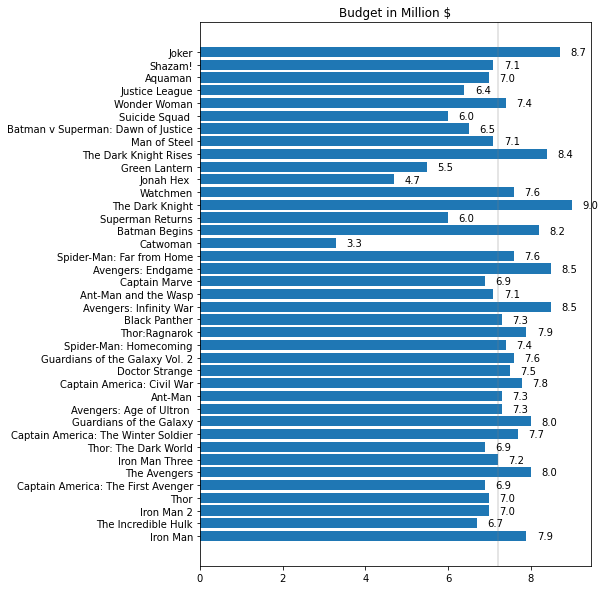

In [44]:
plt.figure(figsize=(7,10))
ax= plt.subplot(111)

AVG_RATE = statistics.mean(marvel_dc['Rate'])
print("The average rating for a marvel/dc is",AVG_RATE)

ax.barh(y=marvel_dc['Original_Title'], width=marvel_dc['Rate'], )

for count, value in enumerate(marvel_dc['Rate']):
    ax.text(x= value+0.25, y= count-0.25, s= value)

ax.axvline(AVG_RATE, color='grey', linewidth=0.4)
    
plt.title('Budget in Million $')
plt.show()